# NLP Final COPA Project: RoBERTa

In [1]:
import numpy as np
import pandas as pd
import torch
from torch import nn, optim, cuda
from torch.utils.data import Dataset, DataLoader
from transformers import RobertaTokenizer, RobertaConfig, RobertaModel, RobertaForSequenceClassification
from datetime import datetime
import matplotlib.pyplot as plt
device = torch.device('cuda' if cuda.is_available() else 'cpu')
# device = 'cpu'
print(device)

cuda


In [2]:
class CopaDataset(Dataset):
    def __init__(self, filename):
        super().__init__()
        self.tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
        text_frame = pd.read_json(filename, lines=True)
        self.X = []
        self.y = []
        for i, row in text_frame.iterrows():
            prem = torch.tensor(self.tokenizer(row['premise'])['input_ids'])
            quest = torch.tensor(self.tokenizer(row['question'])['input_ids'])
            h1 = torch.tensor(self.tokenizer(row['choice1'])['input_ids'])
            h2 = torch.tensor(self.tokenizer(row['choice2'])['input_ids'])
            self.X.append(torch.cat((prem, quest, h1, h2)).to(device))
            self.y.append(torch.tensor(row['label']).to(torch.float32).to(device))
        
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.to_list()
        return self.X[idx], self.y[idx]

In [5]:
# there's a better way to do this wrt the question - it should just be a new token,
#   but I'm worried I'll break it if I try to change things at this point
def load_data(filename):
    with open(filename, 'r', encoding='utf8') as file:
        raw_data = pd.read_json(file, lines=True)
    tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
    dataset = []
    
    for i, row in raw_data.iterrows(): # yeah, yeah, I know...
        prem = torch.tensor(tokenizer(row['premise'])['input_ids']).to(device)
        quest = torch.tensor(tokenizer(row['question'])['input_ids']).to(device)
        h1 = torch.tensor(tokenizer(row['choice1'])['input_ids']).to(device)
        h2 = torch.tensor(tokenizer(row['choice2'])['input_ids']).to(device)
#         X.append((torch.cat((prem, h1, h2))))
#         y.append(torch.tensor(row['label']).to(torch.float32))
        X = [torch.cat((prem, quest)), h1, h2]
        dataset.append((X, torch.tensor(row['label']).to(torch.float32).to(device)))
    
#     dataset = (torch.tensor(X).to(device), torch.tensor(Y).to(device))
    return dataset

In [6]:
train_data = load_data('data/train.jsonl')
# train_data = DataLoader(CopaDataset('data/train.jsonl'), batch_size=64, shuffle=True)
print(f'Training data loaded (length {len(train_data)})')
dev_data = load_data('data/dev.jsonl')
# dev_data = DataLoader(CopaDataset('data/dev.jsonl'), batch_size=64, shuffle=True)
print(f'Dev data loaded (length {len(dev_data)})')
test_data = load_data('data/test.jsonl')
# test_data = DataLoader(CopaDataset('data/test.jsonl'), batch_size=64, shuffle=True)
print(f'Test data loaded (length {len(test_data)})')

Training data loaded (length 350)
Dev data loaded (length 50)
Test data loaded (length 100)


In [2]:
class COPAClassifier(nn.Module):
    def __init__(self, output_size=1):
        super().__init__()
        
        # default pretrained layer
        self.roberta = RobertaModel.from_pretrained('roberta-base')
        self.h11 = nn.Linear(768, 4)
        self.h12 = nn.Linear(768, 2)
        self.h13 = nn.Linear(768, 2)
        self.dropout = nn.Dropout(p=0.6)
#         self.h2 = nn.Linear(700, 350)
#         self.h3 = nn.Linear(350, 100)
#         self.h4 = nn.Linear(100, 16)
        self.classifier = nn.Linear(8, output_size)
        self.sigmoid = nn.Sigmoid()
        self.relu = nn.LeakyReLU()
        
        self.esteem = "I'm SO proud of you"
        
    def forward(self, x):
        out1 = self.relu(self.h11(self.dropout(self.roberta(input_ids=x[0].unsqueeze(0))[1])))
        out2 = self.relu(self.h12(self.dropout(self.roberta(input_ids=x[1].unsqueeze(0))[1])))
        out3 = self.relu(self.h13(self.dropout(self.roberta(input_ids=x[2].unsqueeze(0))[1])))
#         out = self.relu(self.h3(self.relu(self.h2(out))))
        out = self.classifier(torch.cat((out1, out2, out3), dim=1))
        return self.sigmoid(out.squeeze(0).squeeze(0))
    
    def predict(self, x):
        return 1 if (self.forward(x) > 0.5) else 0

In [6]:
# initialize model
copa = COPAClassifier()
copa.to(device)

# 3) Now we train our model. 
start_time = datetime.now()
epochs = 800
report_per = 50
bce = nn.BCELoss()
sigmoid = nn.Sigmoid()
optimizer = optim.SGD(copa.parameters(), lr=1e-4)

dev_acc = np.zeros(epochs)
loss_by_epoch = np.zeros(epochs)
preds_by_epoch = []

for i in range(epochs):
    
    # lr decay
#     if i == 5:
#         optimizer = optim.SGD(copa.parameters(), lr=1e-3)
#     elif i == 50:
#         optimizer = optim.SGD(copa.parameters(), lr=1e-6)
        
    if i % report_per == 0:
        print('### Epoch: ' + str(i+1) + ' ###')
    av_loss = 0
    copa.train()
    for (x, y) in train_data:
        optimizer.zero_grad()
        
        # a) calculate probs / get an output
        y_hat = copa(x)
        
        # b) compute loss
        loss = bce(y_hat, y)
        
        # c) get the gradient
        loss.backward()

        # d) update the weights
        optimizer.step()
        
        av_loss += loss
        
    loss_by_epoch[i] = av_loss/len(train_data)
    
    # validate
    if (i + 1) % report_per == 0:
#         print(f'Validating for epoch {i + 1}')
        copa.eval()
        preds = []
        with torch.no_grad():
            for (x, y) in dev_data:
                y_hat = 1 if copa(x) > 0.5 else 0
                if y_hat == y:
                    dev_acc[i] += 1
            dev_acc[i] /= len(dev_data)
            
            for (x, y) in train_data:
                y_raw = copa(x)
                preds.append(y_raw)
            preds_by_epoch.append(preds)

end_time = datetime.now()
print(f'Training completed in {str(end_time - start_time)}')

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.decoder.weight', 'lm_head.dense.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


### Epoch: 1 ###
### Epoch: 51 ###
### Epoch: 101 ###
### Epoch: 151 ###
### Epoch: 201 ###
### Epoch: 251 ###
### Epoch: 301 ###
### Epoch: 351 ###
### Epoch: 401 ###
### Epoch: 451 ###
### Epoch: 501 ###
### Epoch: 551 ###
### Epoch: 601 ###
### Epoch: 651 ###
### Epoch: 701 ###
### Epoch: 751 ###
Training completed in 13:18:55.470877


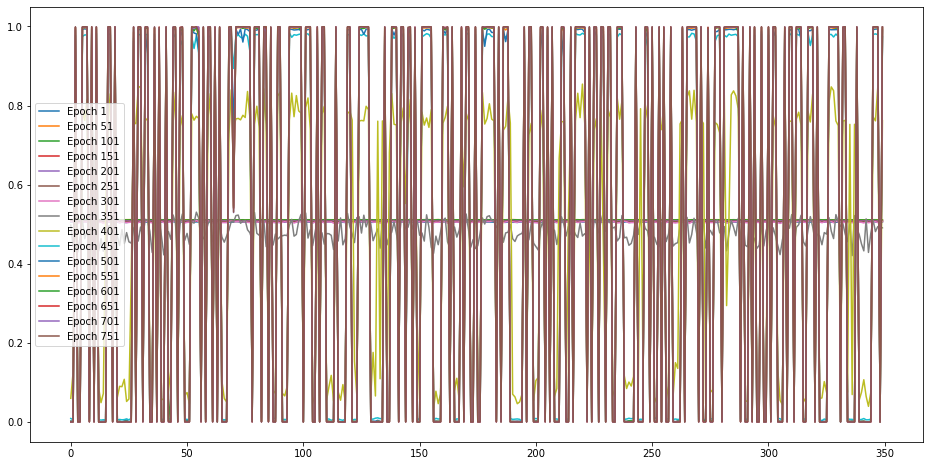

In [7]:
fig, ax = plt.subplots(figsize=(16, 8))
for i in range(len(preds_by_epoch)):
    ax.plot(preds_by_epoch[i], label=f'Epoch {i * report_per + 1}')
ax.legend()
plt.show()

In [29]:
correct = 0
preds = []
copa.eval()
with torch.no_grad():
    for (x, y) in dev_data:
        y_hat = 1 if copa(x) > 0.5 else 0
#         print(y_hat)
    #     y_hat = 1 if copa(x.unsqueeze(0)) > 0.5 else 0
        preds.append(copa.predict(x))
        if y_hat == y:
            correct += 1

acc = correct / len(dev_data)
print(acc)
# print(preds)

0.7114285714285714


In [8]:
acc_by_epoch = []
for epoch in preds_by_epoch:
    correct = 0
    for i, (x, y) in enumerate(train_data):
        y_hat = 1 if epoch[i] > 0.5 else 0
        if y_hat == y:
            correct += 1
    acc_by_epoch.append(correct / len(train_data))

In [41]:
dev_acc_2 = np.copy(dev_acc)
loss_by_epoch_2 = np.copy(loss_by_epoch)
preds_by_epoch_2 = [pred for pred in preds_by_epoch]

In [19]:
print(dev_acc)

[0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.   0.   0.   0.54 0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.54 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.54 0.   0.   0.   0.
 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.54 0.   0.   0. 

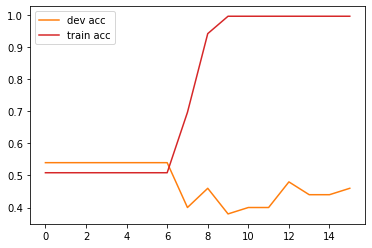

In [9]:
plot, ax = plt.subplots()
# ax2 = ax.twinx()
# ax.plot(loss_by_epoch, label='training acc')
# plot_acc = dict()
# for i, elt in enumerate(dev_acc):
#     if elt != 0:
#         plot_acc[i] = elt
        
ax.plot([elt for elt in dev_acc if elt > 0], color='tab:orange', label='dev acc')
ax.plot(acc_by_epoch, color='tab:red', label='train acc')
# ax2.plot(loss_by_epoch, color='tab:red', label='train loss')
ax.legend()
# ax2.legend()
plt.show()

In [12]:
# save the model
torch.save(copa, 'copa_800.pth')

## Notes
LSTM on top of BERT is probably a bad idea - overlaps; might be better to just use a fully connected linear layer  
Cause/effect token as extra input to the model

In [13]:
copa2 = torch.load('copa_800.pth')

In [18]:
copa2.eval()
correct = 0
with torch.no_grad():
    for (x, y) in dev_data:
        y_hat = 1 if copa2(x) > 0.5 else 0
#         print(y_hat)
    #     y_hat = 1 if copa(x.unsqueeze(0)) > 0.5 else 0
        if y_hat == y:
            print('Correct!')
            correct += 1

acc = correct / len(dev_data)
print(acc)

Correct!
Correct!
Correct!
Correct!
Correct!
Correct!
Correct!
Correct!
Correct!
Correct!
Correct!
Correct!
Correct!
Correct!
Correct!
Correct!
Correct!
Correct!
Correct!
Correct!
Correct!
Correct!
Correct!
0.46


## Evaluation

In [3]:
copa = torch.load('copa_800.pth')

In [8]:
correct = 0
preds = []
copa.eval()
with torch.no_grad():
    for (x, y) in train_data:
        y_hat = 1 if copa(x) > 0.5 else 0
#         print(y_hat)
    #     y_hat = 1 if copa(x.unsqueeze(0)) > 0.5 else 0
        preds.append(copa.predict(x))
        if y_hat == y:
            correct += 1

acc = correct / len(train_data)
print(acc)
# print(preds)

0.9971428571428571
